<a href="https://colab.research.google.com/github/kai-majerus/data-science-portfolio/blob/upload-notebook-from-colab/ladybird-classification/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Notebook, I will train a Yolov8 model on ladybird images. I annotated 1000 images using roboflow and split them into 701 train images, 200 validation images and 99 test images. I uploaded these images to my google drive so that I could use them in this notebook.

I also applied some augmentations to the training data to end up with 2103 train images.

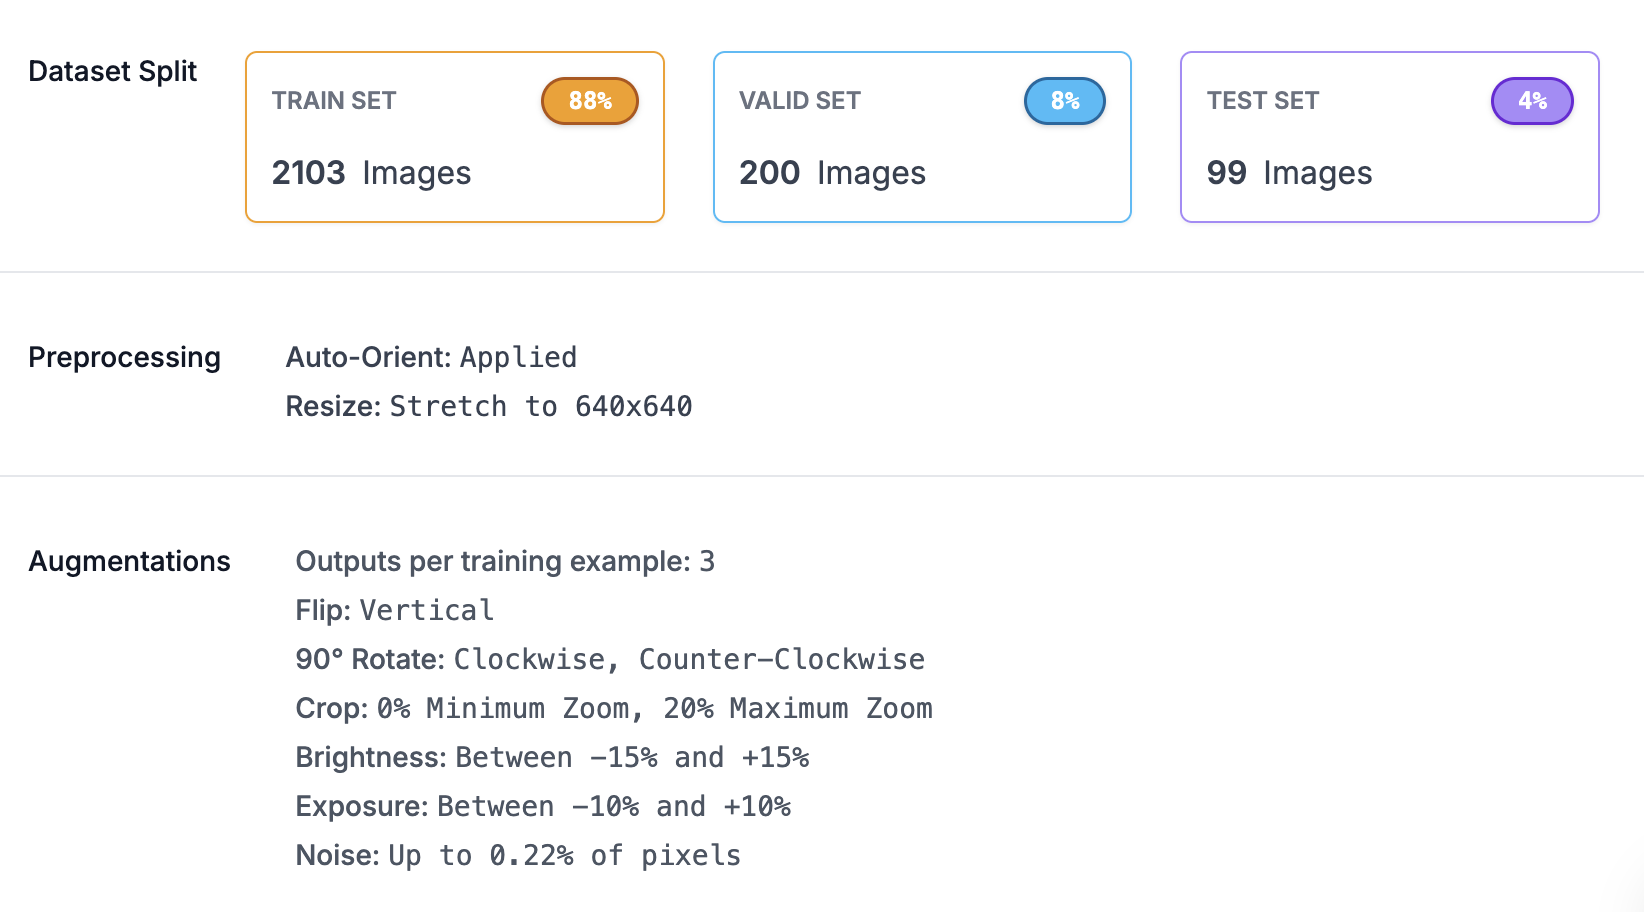

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 29 15:05:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
! pip install ultralytics
! pip install onnx
! pip install mlflow[onnx]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.5/637.5 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt


from ultralytics import YOLO, settings
from PIL import Image

import mlflow
import mlflow.onnx
import onnx
import torch
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Setup and data selection

The YOLO model needs access to the raw images and the box labels. These are referenced in the yaml file. The labelled images are just for plotting purposes.

In [5]:
data_path = '/content/drive/My Drive/Colab Notebooks/data/'

In [6]:
# Setup directories
all_images_dir = data_path + "all/images"
all_boxes_dir = data_path + "all/labels"
all_corrected_images_dir = data_path + "all/labelled_images"
train_images_dir = data_path + "train/images"
train_boxes_dir = data_path + "train/labels"
train_corrected_images_dir = data_path + "train/labelled_images"
val_images_dir = data_path + "val/images"
val_boxes_dir = data_path + "val/labels"
val_corrected_images_dir = data_path + "val/labeled_images"
test_images_dir = data_path + "test/images"
test_boxes_dir = data_path + "test/labels"
test_predictions_dir = data_path + "test/predictions"

os.makedirs(all_images_dir, exist_ok=True)
os.makedirs(all_boxes_dir, exist_ok=True)
os.makedirs(all_corrected_images_dir, exist_ok=True)
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_boxes_dir, exist_ok=True)
os.makedirs(train_corrected_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_boxes_dir, exist_ok=True)
os.makedirs(val_corrected_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_boxes_dir, exist_ok=True)
os.makedirs(test_predictions_dir, exist_ok=True)

# Draw bounding boxes for plotting

In [12]:
# Only wrote this code to check that the label coordinates were matched to the correct images.
# Usually I don't run this section

In [13]:
def overlay_bounding_boxes(image_path, annotation_path, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Read the original image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to read image {image_path}")
        return

    h, w, _ = img.shape  # Image dimensions

    # Read the annotation file
    with open(annotation_path, "r") as file:
        lines = file.readlines()

    for line in lines:
        # Parse the YOLO annotation
        class_id, x_center, y_center, box_width, box_height = map(float, line.strip().split())

        # Convert normalized coordinates to pixel values
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)

        # Draw the bounding box on the image
        color = (0, 255, 0)  # Green color for the bounding box
        thickness = 2  # Line thickness
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

    # Save the image with overlayed bounding boxes
    save_path = os.path.join(output_dir, os.path.basename(image_path))
    cv2.imwrite(save_path, img)

In [14]:
### WARNING This takes quite a while for all the train images.
## Overlay bounding boxes on all images and save them to all/labelled_images

# for image_filename in os.listdir(train_images_dir):
#     if image_filename.endswith(".jpg"):  # Ensure we only process images
#         image_path = os.path.join(train_images_dir, image_filename)
#         annotation_path = os.path.join(train_boxes_dir, image_filename.replace(".jpg", ".txt"))

#         # Check if annotation file exists
#         if os.path.exists(annotation_path):
#             overlay_bounding_boxes(image_path, annotation_path, train_corrected_images_dir)
#         else:
#             print(f"No annotation found for {image_filename}. Skipping.")

In [15]:
def plot_image(image_path):
    annotated_image = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.title("First Annotated Image")
    plt.show()

In [ ]:
# image_paths = [os.path.join(train_corrected_images_dir, image) for image in os.listdir(train_corrected_images_dir)]

In [16]:
# # Plot the first annotated image in the notebook
# first_image_path = image_paths[0]
# plot_image(first_image_path)

# MLFlow setup

In [17]:
mlflow.set_tracking_uri( '/content/drive/My Drive/Colab Notebooks/mlruns/')
mlflow.set_experiment(experiment_id="433345611500746581")

# Use Google Drive as your backend storage - transfer experiments to my local DS portfolio mlruns folder to access in mlflow
# mlflow server --host 127.0.0.1 --port 8080


<Experiment: artifact_location='file:///content/drive/My Drive/Colab Notebooks/mlruns/433345611500746581', creation_time=1736184621641, experiment_id='433345611500746581', last_update_time=1736184621641, lifecycle_stage='active', name='ladybird_yolo_v2', tags={}>

# Model no training

Train a baseline yolo model (no tuning it on ladybird images) to see what the predictions are like

In [18]:
model = YOLO('yolov8s.pt') #n: nano, s: small, m: medium, l: large, x: extra large

100%|██████████| 21.5M/21.5M [00:00<00:00, 154MB/s]


In [19]:
model.task

'detect'

In [20]:
# Run predictions on baseline yolo model
results = model.predict(source=test_images_dir, save=True, save_txt=False, conf=0.5)


image 1/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_101_jpg.rf.fb67a58aea026ca42824a61a51bd3b06.jpg: 640x640 (no detections), 16.6ms
image 2/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_10_jpg.rf.f3be743610adf0261719361640274c03.jpg: 640x640 1 clock, 16.5ms
image 3/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_119_jpg.rf.49295cedd509c48de8768672913bf035.jpg: 640x640 1 person, 16.5ms
image 4/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_126_jpg.rf.f3c1f242bc95547b904c2772867acec9.jpg: 640x640 (no detections), 16.5ms
image 5/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_129_jpg.rf.d2c75cf8de8605264a4b27276042eff6.jpg: 640x640 (no detections), 16.6ms
image 6/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_133_jpg.rf.983070346efb9322dfe8a4989d2d58a6.jpg: 640x640 (no detections), 16.6ms
image 7/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_141_jpg.rf.

We see no detections or incorrect detections.

# Training

In this section I will
- Create a signature that illustrates what the model input and output should look like. This is just for storage purposes in mlflow and might be useful later when creating an app to take in images.
- Tune the model with all of the train images.

Note:

To view the mlflow results, go to colab notebooks and copy the mlruns folder to my local repo. Then replace `file:///content/drive/My Drive/Colab Notebooks/` with an empty string from the artifact location on each of the yaml files.

Infer signature for MLflow

In [21]:
train_image_paths = [os.path.join(train_images_dir, image) for image in os.listdir(train_images_dir)]
first_image_path = train_image_paths[0]
first_image_path

'/content/drive/My Drive/Colab Notebooks/data/train/images/image_280_jpg.rf.0f75dd60ad4c348979bce69c88cca26c.jpg'

array([[[ 54, 121,  76],
        [ 53, 120,  75],
        [ 54, 121,  76],
        ...,
        [102, 172, 125],
        [101, 173, 126],
        [101, 173, 126]],

       [[ 53, 120,  75],
        [ 53, 120,  75],
        [ 53, 120,  75],
        ...,
        [104, 174, 127],
        [102, 174, 127],
        [103, 175, 128]],

       [[ 53, 120,  75],
        [ 53, 120,  75],
        [ 53, 120,  75],
        ...,
        [100, 172, 125],
        [100, 172, 125],
        [101, 173, 126]],

       ...,

       [[ 89,  86, 101],
        [ 88,  85, 100],
        [ 88,  85, 100],
        ...,
        [198, 190, 190],
        [199, 191, 191],
        [199, 191, 191]],

       [[ 89,  86, 101],
        [ 89,  86, 101],
        [ 88,  85, 100],
        ...,
        [198, 190, 190],
        [199, 191, 191],
        [199, 191, 191]],

       [[ 89,  86, 101],
        [ 89,  86, 101],
        [ 88,  85, 100],
        ...,
        [198, 190, 190],
        [199, 191, 191],
        [199, 191, 191]]], dtype=uint8)
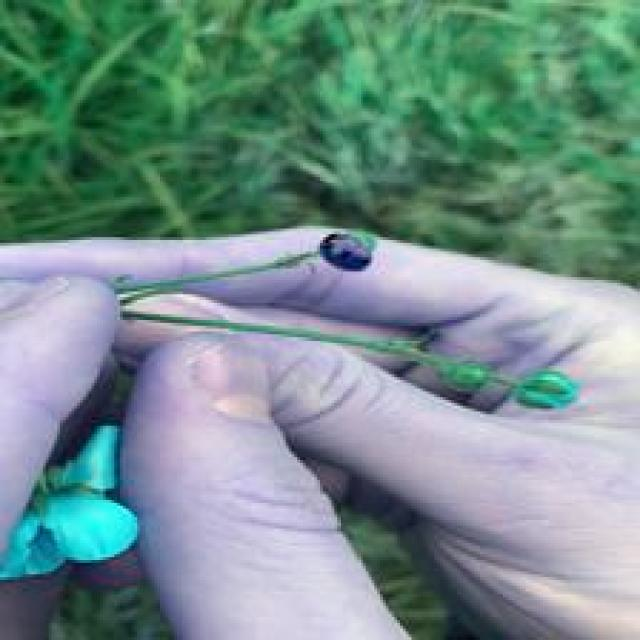

In [22]:
input_image = cv2.imread(first_image_path)  # Replace with a sample image
input_image

In [23]:
input_example = np.transpose(input_image, (2, 0, 1))  # Convert HWC to CHW format
input_example = np.expand_dims(input_example, axis=0).astype(np.float32)  # Add batch dimension

In [24]:
# Convert the NumPy array to a PyTorch tensor if needed
input_tensor = torch.from_numpy(input_example)

# Run a forward pass through the model
# Note: Replace `model` with your actual YOLOv8 model object
sample_output = model(input_tensor)


WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 255.0. Dividing input by 255.
0: 640x640 1 person, 16.6ms
Speed: 1.4ms preprocess, 16.6ms inference, 14.6ms postprocess per image at shape (1, 3, 640, 640)


In [25]:
# Extract the bounding box predictions
predictions = sample_output[0].boxes

# Convert to a NumPy array (YOLOv8 `boxes` may have a method to return this directly)
if hasattr(predictions, 'data'):
    output_example = predictions.data.cpu().numpy()  # Assuming `boxes.data` contains tensor data
else:
    raise ValueError("Unexpected format: Unable to extract bounding box predictions.")

# Check the structure of output_example
print(output_example.shape)  # (num_predictions, num_features)
print(output_example)        # Example: [[x1, y1, x2, y2, confidence, class_id], ...]

(1, 6)
[[    0.42995      274.93      128.34      637.69     0.36286           0]]


In [26]:
signature = infer_signature(input_example, output_example)

## Train and log to MLflow

In [27]:
# Instanciate model
model_version = "yolov8s.pt"
model = YOLO(model_version)

In [28]:
# Set params to log
data_yaml = "data.yaml"
dataset_name = "four_species"
dataset_version = "v2.0"
dataset_train_size = 2103 # Number of images
epochs = 100
batch_size = 32
lr0=0.01
settings.update({'mlflow': False})


# Start an MLflow run
with mlflow.start_run() as run:
    print(f"Run ID: {run.info.run_id}")

    mlflow.log_param("dataset_name", dataset_name)
    mlflow.log_param("dataset_version", dataset_version)
    mlflow.log_param("dataset_train_size", dataset_train_size)

    results = model.train(data= data_path + data_yaml,
                          epochs=epochs,
                          batch=batch_size,
                          imgsz=640)

    if results is not None:
        # Log parameters and metrics
        mlflow.log_param("epochs", epochs)
        mlflow.log_metrics({"precision": results.mean_results()[0]})
        mlflow.log_metrics({"recall": results.mean_results()[1]})
        mlflow.log_metrics({"mAP50": results.mean_results()[2]})
        mlflow.log_metrics({"mAP50-95": results.mean_results()[3]})
        mlflow.log_params({"model": model_version})
        mlflow.log_params({"data": data_yaml})

        # Export the model to ONNX format
        print("Exporting to ONNX format...")
        onnx_model_path = model.export(format="onnx")  # Returns the path as a string

        # Verify ONNX model path and load the model
        if onnx_model_path and isinstance(onnx_model_path, str):
            print(f"ONNX model exported to: {onnx_model_path}")

            # Load the ONNX model using the `onnx` library
            onnx_model = onnx.load(onnx_model_path)  # Load the ONNX file into an ONNX model object

            # Log the ONNX model with MLflow
            mlflow.onnx.log_model(
                onnx_model=onnx_model,
                artifact_path="model",
                input_example=input_example,
                signature=signature
            )
        else:
            print("Failed to export ONNX model.")

        # End the MLflow run
        mlflow.end_run()

Run ID: 528c8ab9870448fc882e635e8a265c27
Ultralytics 8.3.66 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/My Drive/Colab Notebooks/data/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.7MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/My Drive/Colab Notebooks/data/train/labels.cache... 2103 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2103/2103 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/My Drive/Colab Notebooks/data/val/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.59G      1.157      2.876      1.305         50        640: 100%|██████████| 66/66 [00:57<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        200        211      0.379      0.545      0.374      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.56G      1.179      1.771      1.336         40        640: 100%|██████████| 66/66 [00:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211      0.362       0.43      0.333      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.63G      1.163      1.575       1.31         55        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        200        211      0.428      0.315       0.29      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.62G      1.218      1.596       1.35         38        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        200        211      0.483      0.488      0.449      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       7.3G      1.168      1.476      1.311         53        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.497      0.557      0.497      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.31G      1.125      1.343       1.28         37        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211      0.607      0.508      0.566      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.31G      1.102      1.311      1.282         43        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        200        211      0.645       0.65      0.648      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.64G      1.077      1.234      1.257         39        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        200        211      0.699      0.602      0.704       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.63G       1.05      1.204      1.242         43        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.611      0.661      0.659      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.63G      1.024       1.14      1.221         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        200        211       0.76      0.593       0.73      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.63G      1.031       1.12      1.222         35        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.637      0.691      0.734      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.62G       1.01      1.093      1.203         36        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211      0.683      0.708       0.75      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.32G     0.9842      1.028      1.186         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        200        211      0.731      0.753      0.787      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.64G     0.9766     0.9841      1.179         38        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        211      0.758      0.657      0.742      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       7.3G     0.9574      1.047      1.167         43        640: 100%|██████████| 66/66 [00:33<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211      0.742      0.712      0.755      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       7.3G     0.9482     0.9518      1.163         52        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211      0.768      0.739      0.792      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.31G     0.9507     0.9294      1.169         33        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211      0.653      0.679      0.684      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.61G     0.9329     0.9094      1.153         33        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211      0.725      0.681      0.769      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.63G     0.9216      0.891      1.147         29        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.741      0.675      0.756      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       7.3G      0.923     0.8811       1.15         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211        0.7      0.723      0.795      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.63G     0.9165     0.8677      1.145         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        200        211      0.785       0.66      0.772      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       7.3G     0.9108     0.8582      1.147         49        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.794      0.714      0.807      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.63G     0.9009     0.8327      1.128         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        200        211      0.803      0.674      0.791      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.62G     0.8981     0.7951      1.132         39        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211      0.838      0.711      0.807      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.62G      0.862     0.7748      1.102         49        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        200        211      0.806      0.702      0.802      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.64G     0.8904     0.7846      1.119         43        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        200        211      0.835      0.645      0.786      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       7.3G     0.8697     0.7725      1.114         33        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        211      0.819      0.753      0.832      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.63G     0.8499     0.7271      1.101         47        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        200        211       0.74      0.703      0.793        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       7.3G     0.8484     0.7439      1.085         44        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.857      0.717      0.851      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.63G     0.8295      0.697      1.077         37        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        200        211      0.798      0.687      0.787      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       7.3G     0.8264     0.6854      1.074         33        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211       0.79      0.755      0.793      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.63G     0.8305     0.6935      1.084         44        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        200        211       0.79       0.73      0.823      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.31G     0.8088     0.6576      1.074         39        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        200        211      0.812      0.766      0.831      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.63G     0.8175     0.6858      1.077         37        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.787      0.769      0.844      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.64G      0.808     0.6756      1.075         45        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        211      0.788      0.772      0.849      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.63G     0.7942     0.6317      1.066         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        211      0.844      0.759       0.83      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.64G     0.7789     0.6203      1.056         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211      0.813      0.679      0.812      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.64G     0.7924     0.6328      1.069         39        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        200        211      0.789      0.729      0.854      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.63G     0.7812     0.6261      1.048         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        200        211      0.835      0.762      0.857      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.64G     0.7667     0.6035      1.046         33        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        200        211      0.823       0.76      0.845       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.65G     0.7557     0.5989      1.051         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211      0.828      0.775       0.84      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.63G     0.7553      0.603      1.043         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        200        211      0.834      0.756      0.844      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.31G     0.7592     0.5951      1.055         35        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        211      0.874      0.734       0.85      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.31G     0.7511     0.5786      1.038         44        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211      0.769      0.818       0.86      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.64G     0.7419     0.5626      1.032         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        200        211      0.766      0.805      0.841      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.63G      0.741     0.5543      1.029         47        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        200        211      0.792      0.756      0.805      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.64G     0.7304     0.5627      1.029         38        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        200        211      0.802       0.77      0.853      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.33G     0.7118     0.5348      1.015         55        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211      0.807      0.803      0.847      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.33G      0.728     0.5384      1.028         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        200        211      0.828      0.772      0.853      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.32G     0.7221     0.5403      1.024         35        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        200        211      0.869      0.759      0.862      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.64G     0.7206     0.5567       1.03         33        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        200        211      0.793      0.798      0.848      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.62G     0.7079     0.5185      1.017         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        200        211      0.827      0.779      0.851      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.31G     0.6844     0.5175      1.009         45        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        200        211      0.858      0.788      0.873       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.63G     0.6893     0.5036      1.012         36        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        200        211      0.822      0.763      0.852       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.64G     0.7029     0.5187      1.017         45        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        200        211      0.757       0.83      0.843      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.63G     0.6915     0.5034      1.008         49        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        200        211      0.859      0.781      0.884      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.62G     0.6813      0.485     0.9969         36        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.819      0.776      0.843      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.62G     0.6713     0.4927     0.9992         47        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        200        211      0.842      0.796      0.848      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.64G     0.6674     0.4973      1.005         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        211      0.854      0.749      0.862      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.64G     0.6527     0.4804     0.9977         28        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        200        211      0.777      0.835      0.856      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.62G     0.6584     0.4775     0.9916         59        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        200        211      0.861      0.769      0.869      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.31G      0.666     0.4744      0.998         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        200        211      0.819      0.817      0.861      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.62G     0.6459     0.4648     0.9794         49        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        200        211      0.844      0.779      0.856      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.62G     0.6408     0.4564     0.9843         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.796      0.814      0.868       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       7.3G     0.6298     0.4467     0.9743         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        200        211      0.834       0.81      0.858      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.62G     0.6362      0.444     0.9892         31        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.837      0.806      0.872      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.62G     0.6216     0.4421       0.97         35        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.883      0.777      0.878      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.64G     0.6193     0.4538     0.9736         46        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        200        211      0.821      0.828      0.867      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.61G     0.6212     0.4249     0.9725         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        200        211       0.88       0.78       0.88      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.31G     0.6154     0.4266      0.969         29        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        200        211      0.832       0.84       0.88       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       7.3G     0.6049     0.4172     0.9627         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        200        211       0.85        0.8      0.899      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.64G     0.6098     0.4265     0.9684         36        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        200        211      0.853      0.811      0.882      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.31G     0.6019     0.4151     0.9673         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        200        211       0.85      0.819      0.878        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.63G     0.5984     0.4175     0.9685         40        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        200        211      0.838        0.8      0.867      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.64G     0.5914     0.4153     0.9683         53        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        200        211      0.814      0.834      0.865      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.63G     0.5928     0.4198     0.9624         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.784      0.806      0.849      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.63G     0.5956     0.4098     0.9652         34        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        200        211      0.807      0.808      0.859      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.31G     0.5618     0.3897     0.9494         43        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        200        211      0.839      0.804      0.861      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.63G     0.5783     0.4003      0.968         36        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        200        211      0.841      0.803      0.865      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.64G     0.5585     0.3888     0.9454         38        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        200        211      0.861       0.81      0.874      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.62G     0.5523     0.3797     0.9501         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.875      0.792      0.863      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.63G     0.5554     0.3762     0.9488         32        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        200        211      0.873      0.798      0.868      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.63G     0.5631     0.3819     0.9575         39        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.861      0.818      0.869       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.63G     0.5579     0.3806     0.9438         42        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        200        211      0.892      0.826      0.886      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.63G     0.5535     0.3695     0.9462         41        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        200        211       0.87        0.8      0.882      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.63G     0.5352     0.3715     0.9481         46        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        200        211      0.872      0.831      0.889      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.31G     0.5445     0.3712     0.9424         46        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        200        211      0.862      0.844      0.899      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.62G     0.5297     0.3562     0.9402         47        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        200        211      0.879      0.849        0.9      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.64G      0.533     0.3612     0.9462         38        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211      0.902      0.803      0.894      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.63G     0.5292     0.3579     0.9395         31        640: 100%|██████████| 66/66 [00:33<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        200        211       0.89      0.804      0.885       0.69


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.64G      0.441     0.2599     0.8634         24        640: 100%|██████████| 66/66 [00:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        200        211      0.891      0.803      0.873      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       7.3G     0.4246     0.2477     0.8462         25        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        200        211      0.855      0.828      0.874        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       7.3G     0.4112     0.2368      0.843         26        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        200        211       0.88      0.826       0.89      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.63G     0.4026     0.2351     0.8404         24        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        211      0.882      0.825      0.887      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.31G     0.4013     0.2348     0.8403         24        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        200        211       0.88      0.853      0.888      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       7.3G     0.3973     0.2304     0.8381         27        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        200        211      0.851      0.854      0.885      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.63G     0.3908     0.2235     0.8361         25        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        200        211      0.851      0.831       0.88      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.64G     0.3888     0.2246     0.8304         25        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        200        211      0.859      0.842      0.886      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.32G     0.3865     0.2236     0.8352         23        640: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.867      0.842      0.886      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.62G     0.3801     0.2211     0.8315         24        640: 100%|██████████| 66/66 [00:33<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        200        211      0.846      0.851      0.887      0.709



100 epochs completed in 1.011 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.66 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


                   all        200        211       0.85        0.8      0.899      0.717
     Adalia bipunctata         59         64      0.921      0.719      0.896      0.719
Coccinella septempunctata         40         40      0.757       0.85      0.893      0.705
     Harmonia axyridis         50         50      0.822       0.84      0.899       0.71
Propylaea quatuordecimpunctata         51         57      0.901      0.789      0.907      0.735
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train
Exporting to ONNX format...
Ultralytics 8.3.66 🚀 Python-3.11.11 torch-2.5.1+cu121 CPU (Intel Xeon 2.30GHz)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting Au

# Test set - Predict and plot

Now that the model has been trained, I will retrieve the model and evaluate the test set.

In [35]:
# Select the best model - manual at the moment
best_model = YOLO('runs/detect/train/weights/best.pt')

In [50]:
# Evaluate the model on the test dataset
metrics = best_model.val(data=data_path + "data.yaml", split="test", conf=0.5)

print(f'Precision: {metrics.box.p}')
print(f'Recall: {metrics.box.r}')
print(f'mAP50-95: {metrics.box.map}')
print(f'map50: {metrics.box.map50}')


Ultralytics 8.3.66 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/My Drive/Colab Notebooks/data/test/labels.cache... 99 images, 0 backgrounds, 0 corrupt: 100%|██████████| 99/99 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


                   all         99        107       0.76      0.695      0.748      0.629
     Adalia bipunctata         25         26      0.804       0.79      0.849      0.737
Coccinella septempunctata         27         30      0.741      0.667       0.74      0.672
     Harmonia axyridis         24         25      0.688       0.52      0.603      0.497
Propylaea quatuordecimpunctata         23         26      0.807      0.802      0.801       0.61
Speed: 0.6ms preprocess, 11.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/val7
Precision: [    0.80409     0.74074     0.68761     0.80661]
Recall: [     0.7897     0.66667        0.52     0.80226]
mAP50-95: 0.6290354601023549
map50: 0.7482883051889629


In [51]:
metrics.confusion_matrix.matrix

array([[         21,           4,           2,           0,           0],
       [          4,          19,           2,           0,           2],
       [          1,           2,          12,           1,           4],
       [          0,           0,           5,          21,           0],
       [          0,           5,           4,           4,           0]])

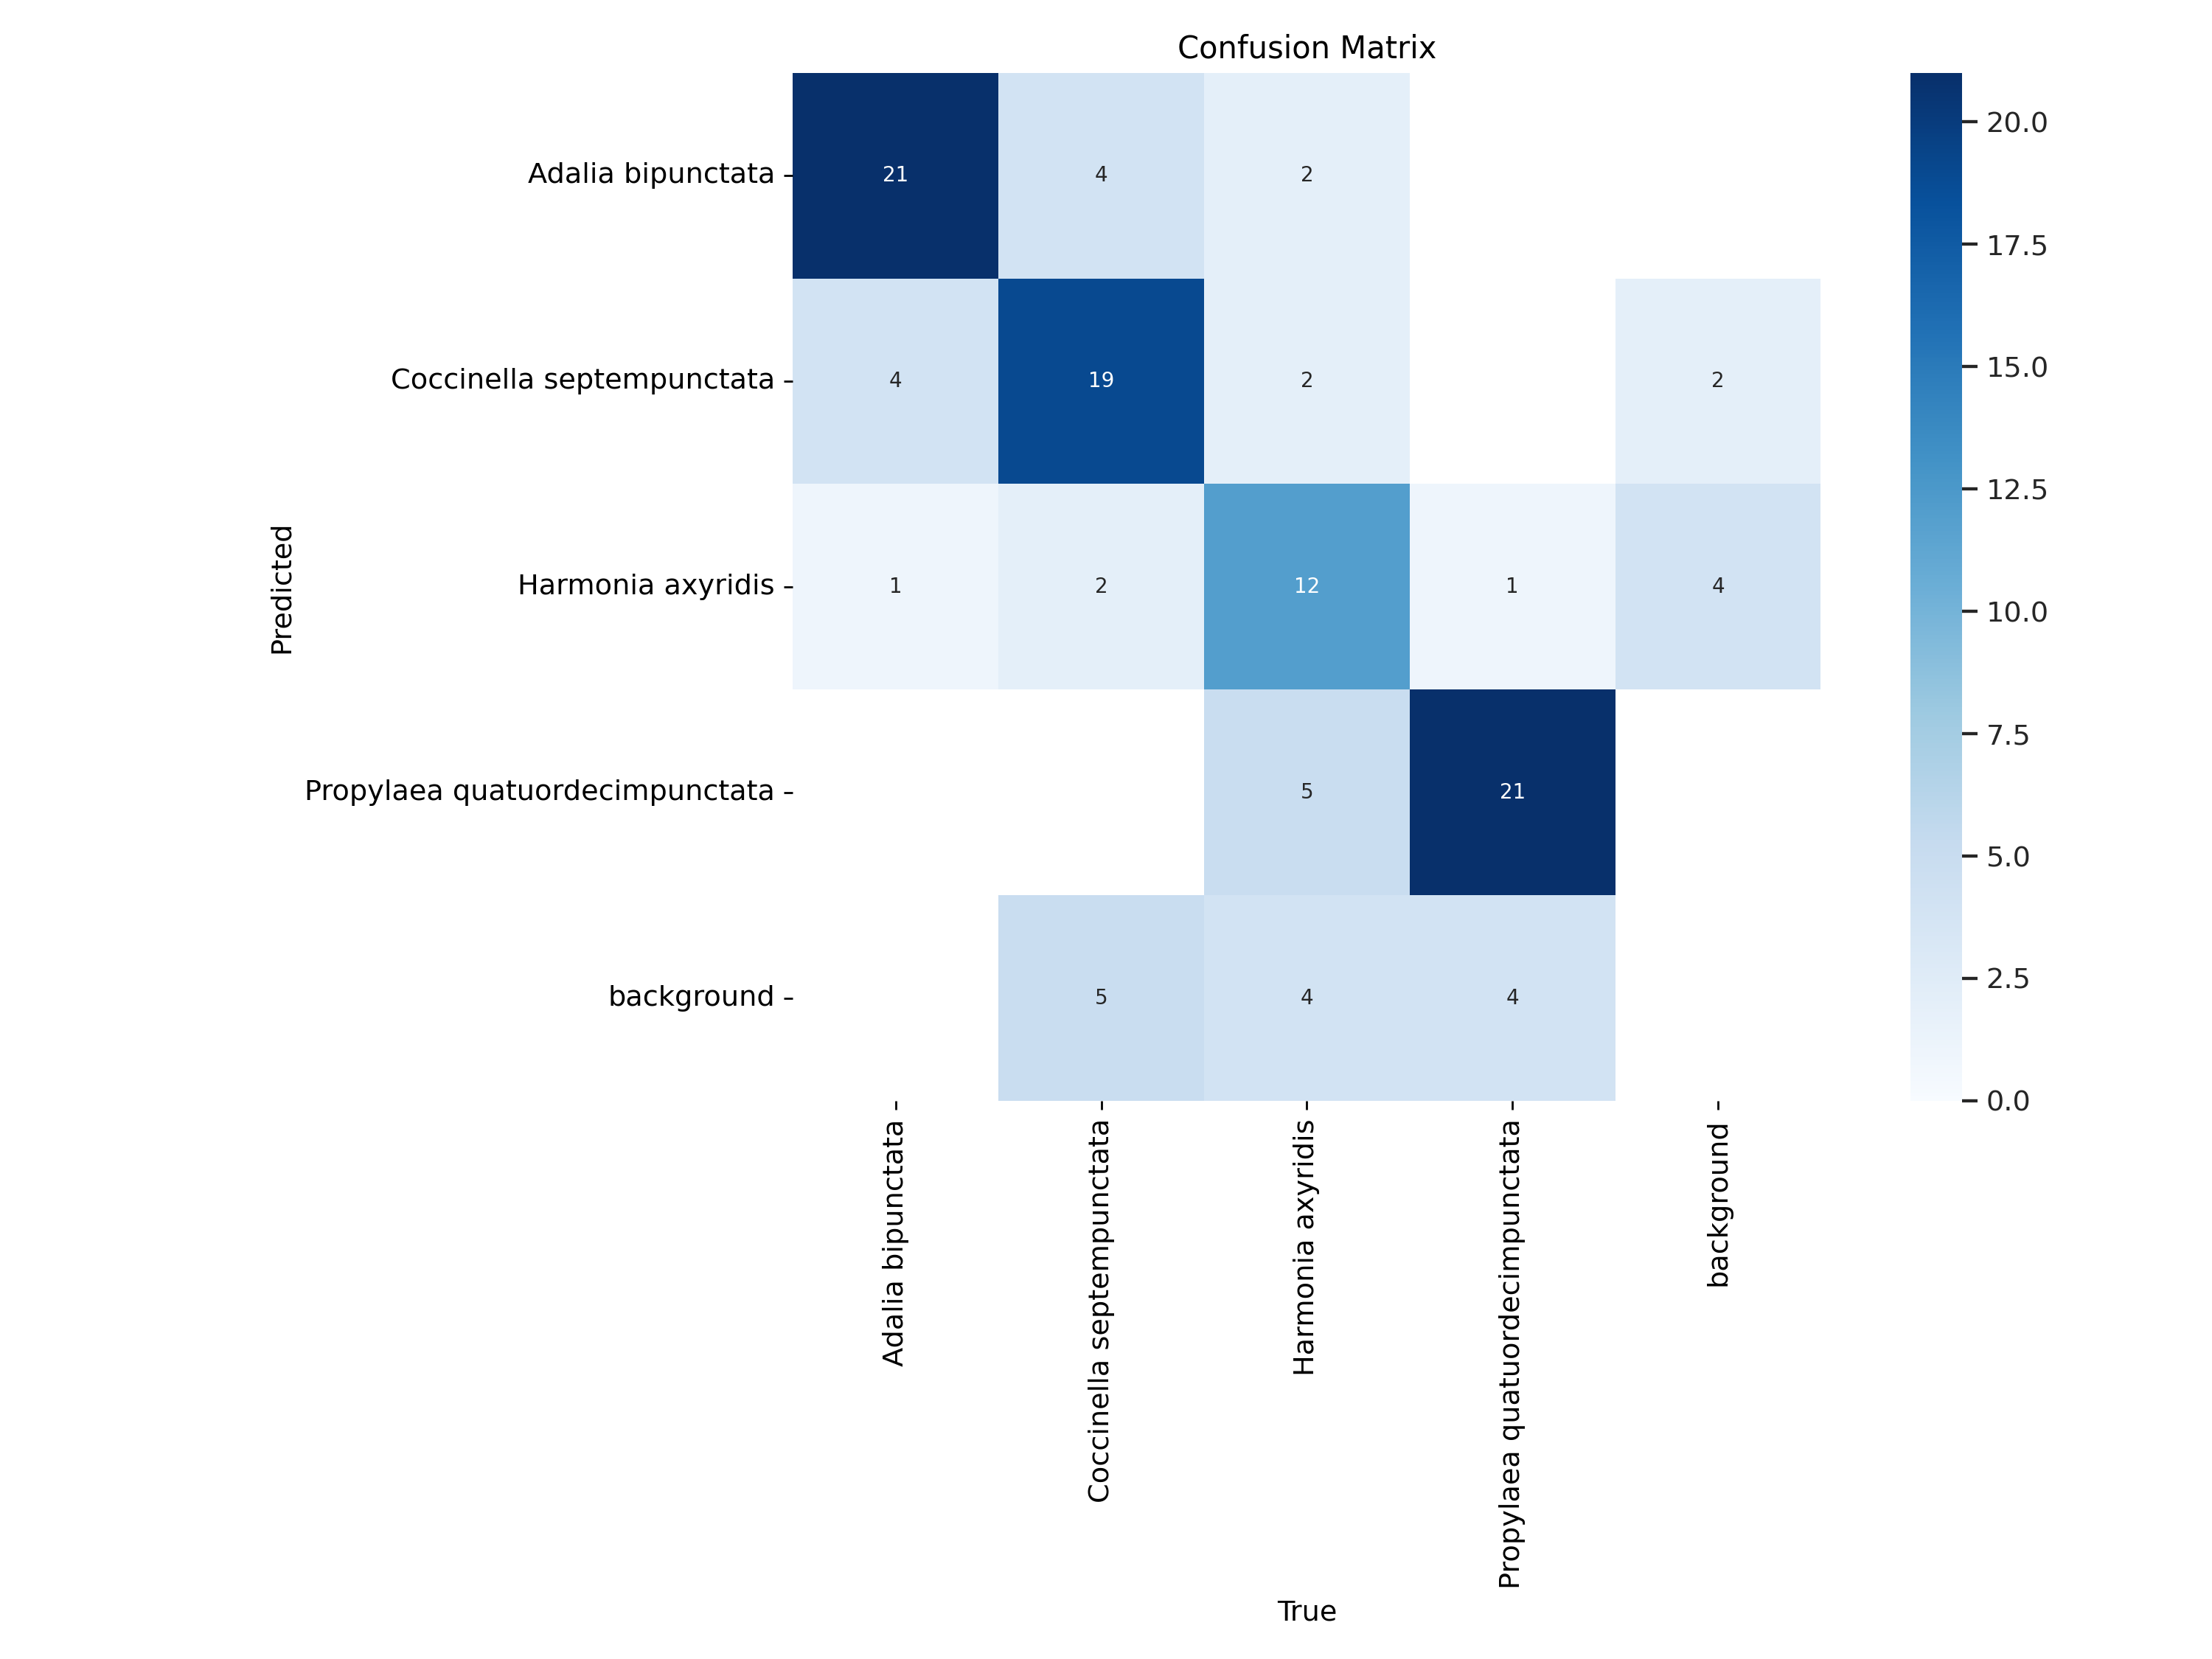

In [52]:
from IPython.display import Image
confusion_matrix_path = 'runs/detect/val7/confusion_matrix.png'
Image(filename=confusion_matrix_path, height=1200, width=1400)

The most common mistake was predicting Adalia Bipunctata when the true class was Harmonia.
The model seems to have a high number of false positives where it predicts one of the 4 ladybird classes when the image is actually just a background image.

This section will plot the predictions on all of the test images for visualisation

In [53]:
# Run predictions and save images with bounding boxes
confidence_threshold = 0.5

test_results = best_model.predict(source= data_path + "test/images", save=True, save_txt=False, conf=confidence_threshold)

# Move the saved images to the output folder
for result in test_results:
    plotted_image = result.plot()

    # Define output file path
    input_image_path = result.path
    image_name = os.path.basename(input_image_path)
    output_image_path = os.path.join(test_predictions_dir, image_name)

    # Save the image
    cv2.imwrite(output_image_path, cv2.cvtColor(plotted_image, cv2.COLOR_RGB2BGR))
    print(f"Saved predicted image to {output_image_path}")

print(f"All predicted images saved to {test_predictions_dir}")


image 1/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_101_jpg.rf.fb67a58aea026ca42824a61a51bd3b06.jpg: 640x640 1 Coccinella septempunctata, 18.0ms
image 2/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_10_jpg.rf.f3be743610adf0261719361640274c03.jpg: 640x640 1 Adalia bipunctata, 16.3ms
image 3/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_119_jpg.rf.49295cedd509c48de8768672913bf035.jpg: 640x640 1 Coccinella septempunctata, 16.2ms
image 4/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_126_jpg.rf.f3c1f242bc95547b904c2772867acec9.jpg: 640x640 1 Adalia bipunctata, 16.3ms
image 5/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_129_jpg.rf.d2c75cf8de8605264a4b27276042eff6.jpg: 640x640 1 Harmonia axyridis, 16.3ms
image 6/99 /content/drive/My Drive/Colab Notebooks/data/test/images/image_133_jpg.rf.983070346efb9322dfe8a4989d2d58a6.jpg: 640x640 1 Adalia bipunctata, 16.2ms
image 7/99 /content/drive/My D

In [7]:
# Get the ladybird species id from the test/box+labels folder. Each image has a .txt in there with the class id
# The class is the first number in the file. e.g. if the file contains 0 0.50234375 0.47890625 0.7953125 0.84921875, then the class is 0
# The class could be two digits, e.g. 11

# get the files and order them by the number in the filename, e.g. image_9, image_44, image_192
def get_image_number_from_filename(filename):
    return int(filename.split("_")[1].split(".")[0])

txt_files = os.listdir(data_path + "test/labels")
txt_files.sort(key=get_image_number_from_filename)

def get_class_id_from_txt(txt_path):
    with open(txt_path, "r") as file:
        line = file.readline()
        class_id = int(line.strip().split()[0])
    return class_id

In [8]:
# Get the class id for each image in the test/box_labels folder
class_ids = []

for txt_filename in txt_files:
    if txt_filename.endswith(".txt"):  # Ensure we only process text files
        txt_path = os.path.join(data_path + "test/labels", txt_filename)
        print(txt_path)
        class_id = get_class_id_from_txt(txt_path)
        class_ids.append(class_id)

class_ids

/content/drive/My Drive/Colab Notebooks/data/test/labels/image_7_jpg.rf.0cb3140520daa351c3a053bbbe9ee3c6.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_10_jpg.rf.f3be743610adf0261719361640274c03.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_27_jpg.rf.5b4398800fce8542e3aad6bdf5b1d85b.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_32_jpg.rf.581541dfd09e10d5c161963f1472f547.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_49_jpg.rf.ac897c5c1d27952d3e3aec5a2680ac68.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_54_jpg.rf.bde17f9f012e05b387017be26301685c.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_74_jpg.rf.bd9be62305e0f9cd77f0906d2181b28d.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_87_jpg.rf.1e4d4606af53db403ac2c6c5b5ef01bb.txt
/content/drive/My Drive/Colab Notebooks/data/test/labels/image_90_jpg.rf.cd52b725fb0e97fadaa7deed01a37453.txt
/content/dr

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [9]:
pred_images = os.listdir(data_path + "test/predictions")
pred_images.sort(key=get_image_number_from_filename)
pred_images

['image_7_jpg.rf.0cb3140520daa351c3a053bbbe9ee3c6.jpg',
 'image_10_jpg.rf.f3be743610adf0261719361640274c03.jpg',
 'image_27_jpg.rf.5b4398800fce8542e3aad6bdf5b1d85b.jpg',
 'image_32_jpg.rf.581541dfd09e10d5c161963f1472f547.jpg',
 'image_49_jpg.rf.ac897c5c1d27952d3e3aec5a2680ac68.jpg',
 'image_54_jpg.rf.bde17f9f012e05b387017be26301685c.jpg',
 'image_74_jpg.rf.bd9be62305e0f9cd77f0906d2181b28d.jpg',
 'image_87_jpg.rf.1e4d4606af53db403ac2c6c5b5ef01bb.jpg',
 'image_90_jpg.rf.cd52b725fb0e97fadaa7deed01a37453.jpg',
 'image_95_jpg.rf.c7c47b08ac19a51f76d83dff81523e2c.jpg',
 'image_98_jpg.rf.781005d807d5ff945760d5f74dd4d895.jpg',
 'image_101_jpg.rf.fb67a58aea026ca42824a61a51bd3b06.jpg',
 'image_119_jpg.rf.49295cedd509c48de8768672913bf035.jpg',
 'image_126_jpg.rf.f3c1f242bc95547b904c2772867acec9.jpg',
 'image_129_jpg.rf.d2c75cf8de8605264a4b27276042eff6.jpg',
 'image_133_jpg.rf.983070346efb9322dfe8a4989d2d58a6.jpg',
 'image_141_jpg.rf.239370325f3834874892887bb026b0fc.jpg',
 'image_152_jpg.rf.7197345

In [10]:
# This order has to line up with how I labelled htem in roboflow, also in data.yaml
id_to_species = {
    0: "Adalia bipunctata",
    1: "Coccinella septempunctata",
    2: "Harmonia axyridis",
    3: "Propylea quatuordecimpunctata",
}

In [ ]:
# Change conf parameter in the predict method to change the confidence threshold
data_to_plot = zip(class_ids, pred_images)
data_to_plot = list(data_to_plot)

plt.figure(figsize=(40, 40))
for i, (class_id, image_path) in enumerate(data_to_plot):
    if image_path.endswith(".jpg"):  # Ensure we only process images
        image_path = os.path.join(data_path + "test/predictions", image_path)
        img = cv2.imread(image_path)
        plt.subplot(10, 10, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(id_to_species[class_id])
plt.savefig("test-preds-plot.png", bbox_inches="tight")  # Save the plot
plt.show()

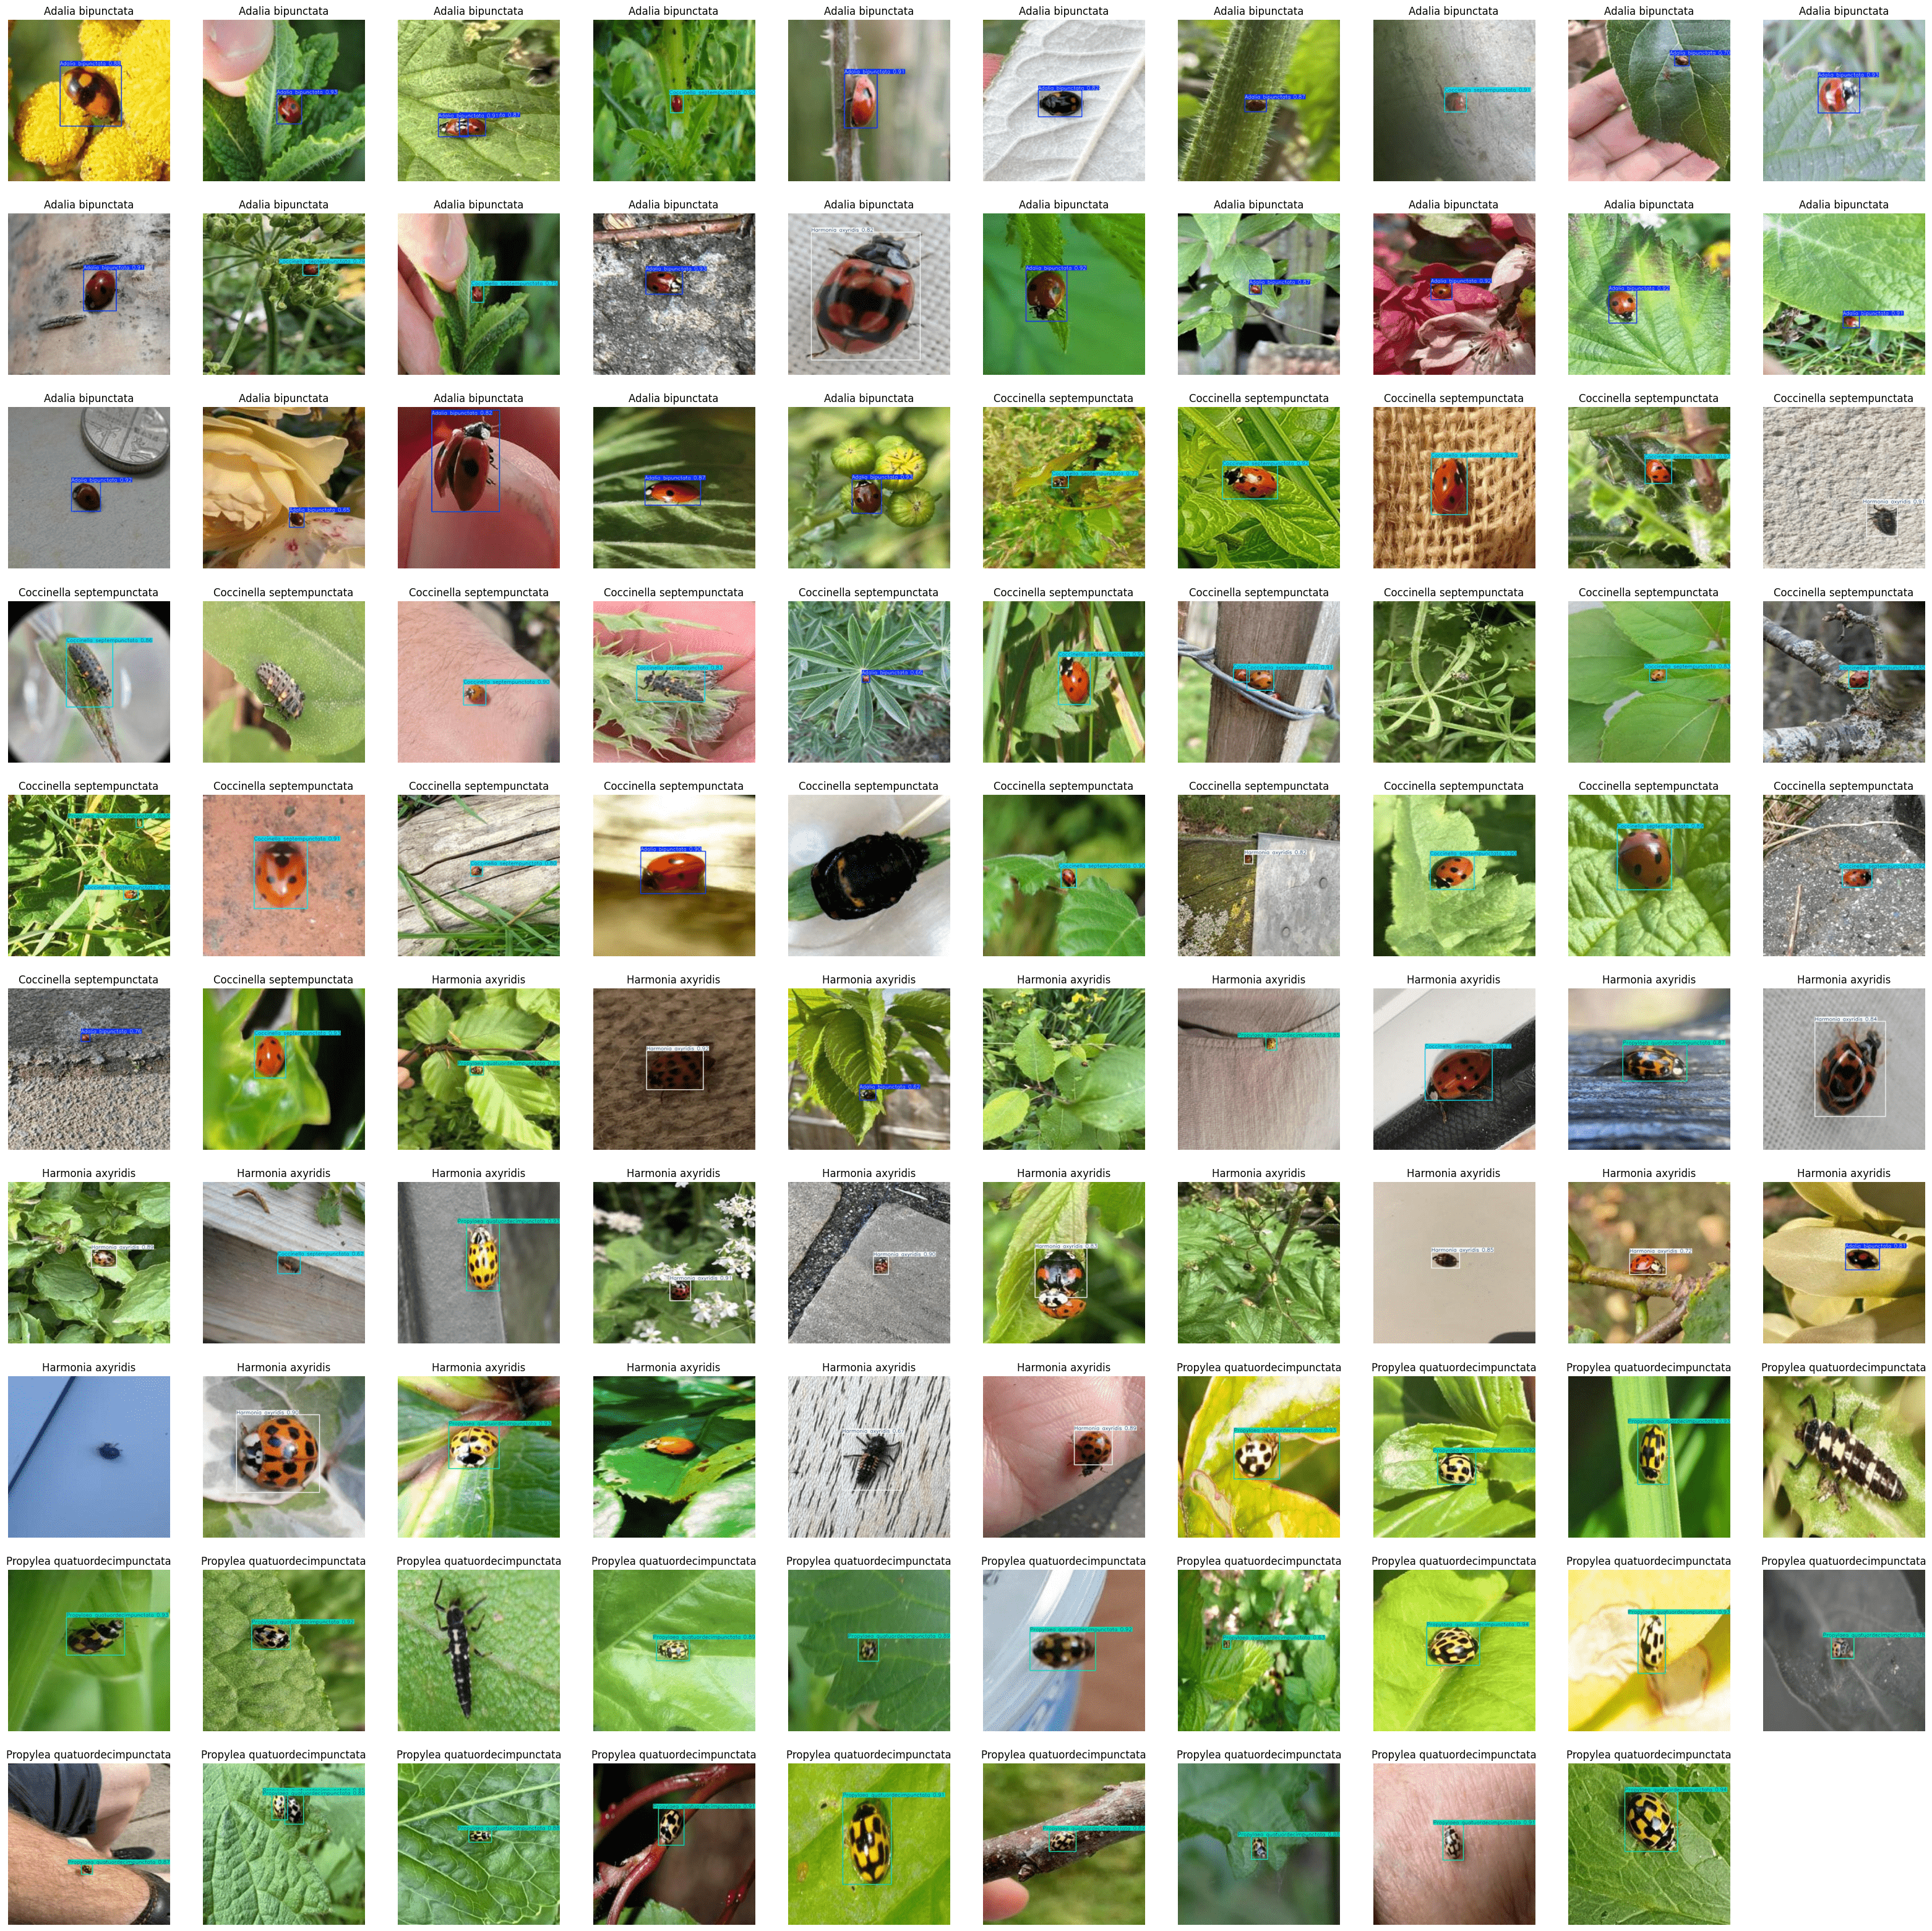

In [2]:
from IPython.display import display, Image
display(Image("test-preds-plot-min.png"))  # Explicitly display the saved image

Problem
- Can it distinguish between the 4 most common classes?
- If yes, can it distinguish between the 4 most common classes and some other images without ladybirds?
- If yes, can it distinguish between even more classes? Would need to label some of each class.

Next steps
- It seems to do ok at distinguishing between the 4 classes. However, it still misses some ladybirds altogheter (predicted background on 5 images that actually had ladybirds) and it predicted a ladybird on.

- If I wanted to improve the model further, I would try to understand why the model is detecting ladybirds where there is not one. Maybe I need more examples of just background images in the dataset? Can this be done automatically when training the model?

- Understand why the model is missing some ladybirds altogether.

- Play around with the confidence threshold to find the best one.